In [24]:
import cudf
import cupy as cp
import numpy as np
import time
import zarr

In [2]:
!conda install -c conda-forge zarr

Solving environment: done

# All requested packages already installed.



In [25]:
sizes = np.power(10, np.arange(1,9))
sizes = np.concatenate((sizes, np.array([264241152])))
print(sizes)

[       10       100      1000     10000    100000   1000000  10000000
 100000000 264241152]


In [49]:
input_size = []
cascaded_size = []
cascaded_temp_size = []
cascaded_round_trip_time = []
lz4_gpu_size = []
lz4_gpu_temp_size = []
lz4_gpu_round_trip_time = []
lz4_size = []
lz4_round_trip_time = []

In [53]:
def compress(compressor, data):
    s = cp.cuda.Stream()
    data_size = data.size * data.itemsize
    compressor_temp_size = np.zeros((1,), dtype=np.int64)
    max_output_size = np.zeros((1,), dtype=np.int64)
    compressor.configure(data_size, compressor_temp_size, max_output_size)
    compressor_temp_cu = cp.zeros((compressor_temp_size[0],), dtype=cp.uint8)
    compressor_output_cu = cp.zeros((max_output_size[0],), dtype=cp.uint8)
    compressor_output_size = cp.zeros((1,), cp.int64)
    compressor.compress_async(
        data_gpu,
        data_size,
        compressor_temp_cu,
        compressor_temp_size,
        compressor_output_cu,
        compressor_output_size,
        stream=s.ptr)
    s.synchronize()
    return compressor_output_cu, compressor_output_size[0], compressor_temp_size[0]

def decompress(decompressor, data, result):
    s = cp.cuda.Stream()
    decompressor_temp_size = np.zeros((1,), np.int64)
    decompressor_output_size = np.zeros((1,), np.int64)
    decompressor.configure(
        data,
        data.size * data.itemsize,
        decompressor_temp_size,
        decompressor_output_size,
        stream=s.ptr)
    
    decompressor_temp_cu = cp.zeros((decompressor_temp_size[0],), dtype=cp.uint8)
    
    decompressor.decompress_async(
        data,
        data.size * data.itemsize,
        decompressor_temp_cu,
        decompressor_temp_size[0],
        result,
        result.size * result.itemsize,
        stream=s.ptr)
    
    s.synchronize()

    return decompressor_temp_size[0]

In [88]:
input_size = []
cascaded_size = []
cascaded_temp_size = []
cascaded_round_trip_time = []
lz4_gpu_size = []
lz4_gpu_temp_size = []
lz4_gpu_round_trip_time = []
lz4_size = []
lz4_round_trip_time = []
for size in sizes:
    data_host = np.random.randint(0, size, size)
    data_gpu = cp.array(data_host)
    """Cascaded GPU"""
    t_gpu = time.time()
    compressor = cudf._lib.nvcomp.CascadedCompressor(cudf._lib.nvcomp.pyNvcompType_t.pyNVCOMP_TYPE_INT.value, 2, 1, True)
    compressed, output_size, temp_size = compress(compressor, data_gpu)

    decompressor = cudf._lib.nvcomp.CascadedDecompressor()
    decompressed_size = decompress(decompressor, compressed, data_gpu)
    cascaded_round_trip_time.append(time.time() - t_gpu)
    input_size.append(data_gpu.size * data_gpu.itemsize)
    cascaded_size.append(output_size.item())
    cascaded_temp_size.append(temp_size)
    print('-----')
    print('Input size: ', data_gpu.size * data_gpu.itemsize)
    print('Cascaded GPU compressor output size: ', output_size)
    print('Cascaded GPU decompressor temp size: ', temp_size)
    print('Cascaded GPU decompressor output size: ', decompressed_size)
    print('Cascaded GPU compress/decompress round trip time: ',time.time() - t_gpu)
        
    """LZ4 GPU"""
    data_gpu = cp.array(data_host)
    t_gpu = time.time()
    compressor = cudf._lib.nvcomp.LZ4Compressor()
    compressed, output_size, temp_size = compress(compressor, data_gpu)

    decompressor = cudf._lib.nvcomp.LZ4Decompressor()
    decompressed_size = decompress(decompressor, compressed, data_gpu)
    lz4_gpu_round_trip_time.append(time.time() - t_gpu)
    lz4_gpu_size.append(output_size.item())
    lz4_gpu_temp_size.append(temp_size)
    print('lz4 GPU compressor output size: ', output_size)
    print('lz4 GPU decompressor temp size: ', temp_size)
    print('lz4 GPU decompressor output size: ', decompressed_size)
    print('lz4 GPU compress/decompress round trip time: ',time.time() - t_gpu)
        
    """LZ4 Host"""
    lz4 = zarr.LZ4()
    t_host = time.time()
    host_compressed = lz4.encode(data_gpu.get())
    host_decompressed = lz4.decode(host_compressed)
    print('Lz4 zarr time: ', time.time() - t_host)
    print('Lz4 compressed size: ', len(host_compressed))
    lz4_size.append(len(host_compressed))
    lz4_round_trip_time.append(time.time() - t_host)

called it self.c.configure
-----
Input size:  80
Cascaded GPU compressor output size:  240
Cascaded GPU decompressor temp size:  2488
Cascaded GPU decompressor output size:  4096
Cascaded GPU compress/decompress round trip time:  0.007380962371826172
lz4 GPU compressor output size:  86
lz4 GPU decompressor temp size:  99623
lz4 GPU decompressor output size:  68
lz4 GPU compress/decompress round trip time:  0.002209186553955078
{'id': 'lz4', 'acceleration': 1}
Lz4 zarr time:  0.24153637886047363
Lz4 compressed size:  43
called it self.c.configure
-----
Input size:  800
Cascaded GPU compressor output size:  424
Cascaded GPU decompressor temp size:  4108
Cascaded GPU decompressor output size:  5632
Cascaded GPU compress/decompress round trip time:  0.002678394317626953
lz4 GPU compressor output size:  407
lz4 GPU decompressor temp size:  99623
lz4 GPU decompressor output size:  68
lz4 GPU compress/decompress round trip time:  0.0020110607147216797
{'id': 'lz4', 'acceleration': 1}
Lz4 zarr

In [57]:
import zarr
import pandas as pd
# zarr lz4 max buffer size is 264241152 int64s
# zarr lz4 max buffer size is 2113929216 bytes
# cascaded max buffer size is 2147483640 bytes
# cascaded max buffer size is 268435456 int64s

In [69]:
print(input_size)
print(cascaded_size)
print(cascaded_temp_size)
print(cascaded_round_trip_time)
print(lz4_gpu_size)
print(lz4_gpu_temp_size)
print(lz4_gpu_round_trip_time)
print(lz4_size)
print(lz4_round_trip_time)
df = pd.DataFrame({
    'Input Size (Bytes)': input_size,
    'cascaded_size': cascaded_size,
    'cascaded_temp_size': cascaded_temp_size,
    'cascaded_round_trip_time': cascaded_round_trip_time,
    'lz4_gpu_size': lz4_gpu_size,
    'lz4_gpu_temp_size': lz4_gpu_temp_size,
    'lz4_gpu_round_trip_time': lz4_gpu_round_trip_time,
    'lz4_size': lz4_size,
    'lz4_round_trip_time': lz4_round_trip_time
})

[80, 800, 8000, 80000, 800000, 8000000, 80000000, 800000000, 2113929216]
[244, 480, 3476, 37724, 500220, 5250224, 62500224, 750000220, 2047869148]
[2488, 4108, 23332, 206080, 2451072, 24263168, 240418815, 2404168959, 6352799743]
[0.0053615570068359375, 0.0022509098052978516, 0.0014677047729492188, 0.0018892288208007812, 0.015133142471313477, 0.0031785964965820312, 0.012970209121704102, 0.10655093193054199, 0.31195807456970215]
[87, 421, 3818, 37395, 404349, 4498231, 49578814, 530845270, 1468928599]
[99623, 99623, 99623, 198223, 1282823, 12128823, 120391623, 1203709823, 3180443135]
[0.0004494190216064453, 0.0006291866302490234, 0.0030059814453125, 0.016684770584106445, 0.016307830810546875, 0.018458843231201172, 0.03479599952697754, 0.33598804473876953, 0.9805629253387451]
[43, 371, 3654, 38735, 414111, 4712690, 50643657, 552759750, 1531235329]
[0.19612979888916016, 0.00035190582275390625, 0.0015630722045898438, 0.0019919872283935547, 0.0050776004791259766, 0.02769780158996582, 0.333199

In [70]:
!conda install -c conda-forge plotly

Solving environment: done

# All requested packages already installed.



In [89]:
df['Cascaded Compression Ratio'] = df['Input Size (Bytes)'] / df['cascaded_size']
df['Lz4 Gpu Compression Ratio'] = df['Input Size (Bytes)'] / df['lz4_gpu_size']
df['Lz4 Host Compression Ratio'] = df['Input Size (Bytes)'] / df['lz4_size']
df['Cascaded Temp Buffer Size Ratio'] = df['cascaded_temp_size'] / df['Input Size (Bytes)']
df['Lz4 Temp Buffer Size Ratio'] = df['lz4_gpu_temp_size'] / df['Input Size (Bytes)']
df['Cascaded Speedup'] = df['lz4_round_trip_time'] / df['cascaded_round_trip_time']
df['Lz4 Gpu Speedup'] = df['lz4_round_trip_time'] / df['lz4_gpu_round_trip_time']
print(df.columns)

Index(['Input Size (Bytes)', 'cascaded_size', 'cascaded_temp_size',
       'cascaded_round_trip_time', 'lz4_gpu_size', 'lz4_gpu_temp_size',
       'lz4_gpu_round_trip_time', 'lz4_size', 'lz4_round_trip_time',
       'Cascaded Compression Ratio', 'Lz4 Gpu Compression Ratio',
       'Lz4 Host Compression Ratio', 'Cascaded Temp Buffer Size Ratio',
       'Cascaded Speedup', 'Lz4 Gpu Speedup', 'Lz4 Temp Buffer Size Ratio'],
      dtype='object')


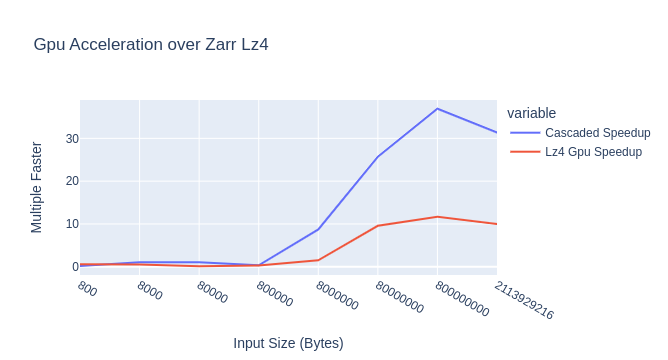

In [95]:
import plotly.express as px
title = 'Gpu Acceleration over Zarr Lz4'
subtitle = 'Includes host->gpu copy time'
fig = px.line(df[1:], x='Input Size (Bytes)',
              y=['Cascaded Speedup', 'Lz4 Gpu Speedup'],
              labels={'value': 'Multiple Faster'},
              title=title)
fig.update_xaxes(type='category')
fig.show()

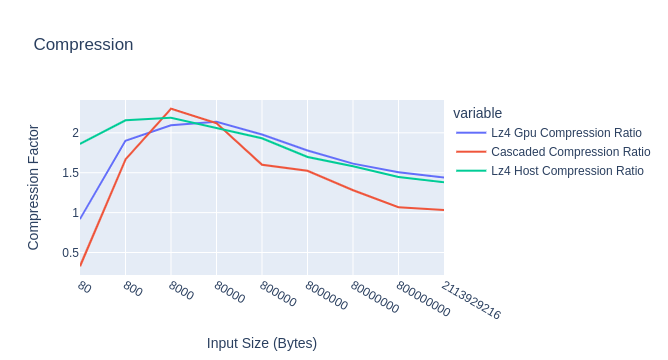

In [96]:
import plotly.express as px
fig = px.line(df, x='Input Size (Bytes)',
              y=[
                  'Lz4 Gpu Compression Ratio',
                  'Cascaded Compression Ratio',
                  'Lz4 Host Compression Ratio'
              ],
              labels={'value': 'Compression Factor'},
              title="Compression")
fig.update_xaxes(type='category')
fig.show()

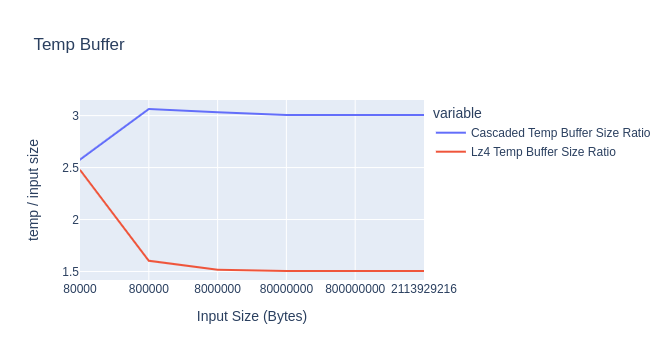

In [97]:
import plotly.express as px
fig = px.line(df[3:], x='Input Size (Bytes)',
              y=['Cascaded Temp Buffer Size Ratio', 'Lz4 Temp Buffer Size Ratio'],
              labels={'value': 'temp / input size'},
              title="Temp Buffer")
fig.update_xaxes(type='category')
fig.show()

In [13]:
df = px.data.gapminder().query("continent=='Oceania'")
print(df)

          country continent  year  lifeExp       pop    gdpPercap iso_alpha  \
60      Australia   Oceania  1952   69.120   8691212  10039.59564       AUS   
61      Australia   Oceania  1957   70.330   9712569  10949.64959       AUS   
62      Australia   Oceania  1962   70.930  10794968  12217.22686       AUS   
63      Australia   Oceania  1967   71.100  11872264  14526.12465       AUS   
64      Australia   Oceania  1972   71.930  13177000  16788.62948       AUS   
65      Australia   Oceania  1977   73.490  14074100  18334.19751       AUS   
66      Australia   Oceania  1982   74.740  15184200  19477.00928       AUS   
67      Australia   Oceania  1987   76.320  16257249  21888.88903       AUS   
68      Australia   Oceania  1992   77.560  17481977  23424.76683       AUS   
69      Australia   Oceania  1997   78.830  18565243  26997.93657       AUS   
70      Australia   Oceania  2002   80.370  19546792  30687.75473       AUS   
71      Australia   Oceania  2007   81.235  20434176

In [14]:
def lz4_compress(compressor, data):
    s = cp.cuda.Stream()
    data_size = data.size * data.itemsize
    compressor_temp_size = np.zeros((1,), dtype=np.int64)
    max_output_size = np.zeros((1,), dtype=np.int64)
    compressor.configure(data_size, compressor_temp_size, max_output_size)
    compressor_temp_cu = cp.zeros((compressor_temp_size[0],), dtype=cp.uint8)
    compressor_output_cu = cp.zeros((max_output_size[0],), dtype=cp.uint8)
    compressor_output_size = cp.zeros((1,), cp.int64)
    compressor.compress_async(
        data_gpu,
        data_size,
        compressor_temp_cu,
        compressor_temp_size,
        compressor_output_cu,
        compressor_output_size,
        stream=s.ptr)
    s.synchronize()
    print('compressor input size: ', data_size)
    print('compressor output size: ', compressor_output_size[0])
    input_size.append(data_size)
    cascaded_size.append(compressor_output_size[0].item())
    return compressor_output_cu

def lz4_decompress(decompressor, data, result):
    s = cp.cuda.Stream()
    decompressor_temp_size = np.zeros((1,), np.int64)
    decompressor_output_size = np.zeros((1,), np.int64)
    decompressor.configure(
        data,
        data.size * data.itemsize,
        decompressor_temp_size,
        decompressor_output_size,
        stream=s.ptr)
    
    print('decompressor temp size: ', decompressor_temp_size[0])
    print('decompressor output size: ', decompressor_output_size[0])
    cascaded_temp_size.append(decompressor_temp_size[0])
    
    decompressor_temp_cu = cp.zeros((decompressor_temp_size[0],), dtype=cp.uint8)
    
    decompressor.decompress_async(
        data,
        data.size * data.itemsize,
        decompressor_temp_cu,
        decompressor_temp_size[0],
        result,
        result.size * result.itemsize,
        stream=s.ptr)
    
    s.synchronize()

    return data_gpu

In [15]:
help(zarr.LZ4.encode)
x = zarr.LZ4()
x.encode(np.array([1,2,3,4]))

Help on cython_function_or_method in module numcodecs.lz4:

encode(self, buf)
    LZ4.encode(self, buf)



b' \x00\x00\x00"\x01\x00\x01\x00\x12\x02\x07\x00#\x00\x03\x08\x00\x80\x04\x00\x00\x00\x00\x00\x00\x00'